# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain Data

Read csv file with Tempurature data into Pandas and drop non-NYC tempurature columns

In [2]:
df = pd.read_csv('Data/temperature.csv')
df = df[['datetime','New York']]
df.columns = ['Period', 'NYC Tempurature']
df.head()

,Period,NYC Tempurature
0,10/1/12 12:00,NaN
1,10/1/12 13:00,288.220000
2,10/1/12 14:00,288.247676
3,10/1/12 15:00,288.326940
4,10/1/12 16:00,288.406203


# Scrub Data

Use df.info() to determine what dataset scrubbing needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 2 columns):
Period             45253 non-null object
NYC Tempurature    44460 non-null float64
dtypes: float64(1), object(1)
memory usage: 707.2+ KB


Change Period column data type to datetime

In [4]:
df['Period'] = pd.to_datetime(df['Period'], dayfirst=False)
df.head()

,Period,NYC Tempurature
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,288.220000
2,2012-10-01 14:00:00,288.247676
3,2012-10-01 15:00:00,288.326940
4,2012-10-01 16:00:00,288.406203


View missing time series values

In [5]:
df[df['NYC Tempurature'].isna()]

,Period,NYC Tempurature
0,2012-10-01 12:00:00,NaN
44461,2017-10-28 01:00:00,NaN
44462,2017-10-28 02:00:00,NaN
44463,2017-10-28 03:00:00,NaN
44464,2017-10-28 04:00:00,NaN
...,...,...
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN


Remove rows with missing tempurature values at start and end of time series

In [6]:
df = df.loc[1:44460, :]
df

,Period,NYC Tempurature
1,2012-10-01 13:00:00,288.220000
2,2012-10-01 14:00:00,288.247676
3,2012-10-01 15:00:00,288.326940
4,2012-10-01 16:00:00,288.406203
5,2012-10-01 17:00:00,288.485467
...,...,...
44456,2017-10-27 20:00:00,289.980000
44457,2017-10-27 21:00:00,289.480000
44458,2017-10-27 22:00:00,287.920000
44459,2017-10-27 23:00:00,285.830000


Plot time series dataset to look for outliers

[Text(0, 0, '2012-10-01T13:00:00.000000000'),
 Text(0, 0, '2012-10-01T14:00:00.000000000'),
 Text(0, 0, '2012-10-01T15:00:00.000000000'),
 Text(0, 0, '2012-10-01T16:00:00.000000000'),
 Text(0, 0, '2012-10-01T17:00:00.000000000'),
 Text(0, 0, '2012-10-01T18:00:00.000000000'),
 Text(0, 0, '2012-10-01T19:00:00.000000000')]

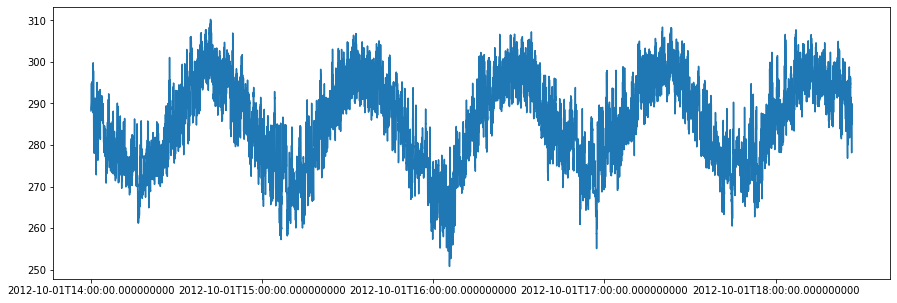

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['NYC Tempurature'].values)
ax.set_xticklabels(df['Period'].values)

Use df.info() to confirm dataset now scrubbed

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44460 entries, 1 to 44460
Data columns (total 2 columns):
Period             44460 non-null datetime64[ns]
NYC Tempurature    44460 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 694.8 KB


# Explore data

Calculate the descriptive statistics for tempurature

In [9]:
df['NYC Tempurature'].describe()

count    44460.000000
mean       285.400406
std         10.220932
min        250.774000
25%        277.370000
50%        285.870000
75%        293.760000
max        310.240000
Name: NYC Tempurature, dtype: float64

Plot the time series dataset

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'NYC Tempurature by Hour')

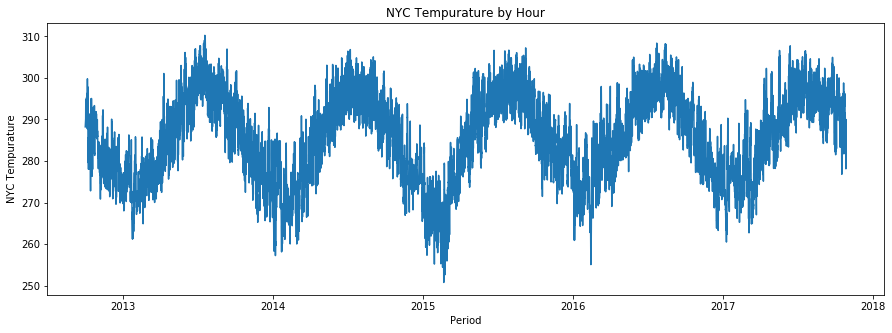

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Period', y='NYC Tempurature', data=df, ax=ax)
ax.set_title('NYC Tempurature by Hour')

Create time series df with month, day and year columns

In [11]:
eda_df = df.copy()
eda_df['Year'] = pd.DatetimeIndex(df['Period']).year
eda_df['Month'] = pd.DatetimeIndex(df['Period']).month
eda_df['Day'] = pd.DatetimeIndex(df['Period']).day
eda_df['Day of Year'] = pd.DatetimeIndex(df['Period']).dayofyear
eda_df['Hour'] = pd.DatetimeIndex(df['Period']).hour
eda_df.head()

,Period,NYC Tempurature,Year,Month,Day,Day of Year,Hour
1,2012-10-01 13:00:00,288.220000,2012,10,1,275,13
2,2012-10-01 14:00:00,288.247676,2012,10,1,275,14
3,2012-10-01 15:00:00,288.326940,2012,10,1,275,15
4,2012-10-01 16:00:00,288.406203,2012,10,1,275,16
5,2012-10-01 17:00:00,288.485467,2012,10,1,275,17


Plot yearly trend in time series data

Text(0.5, 1.0, 'Average NYC Tempurature by Year')

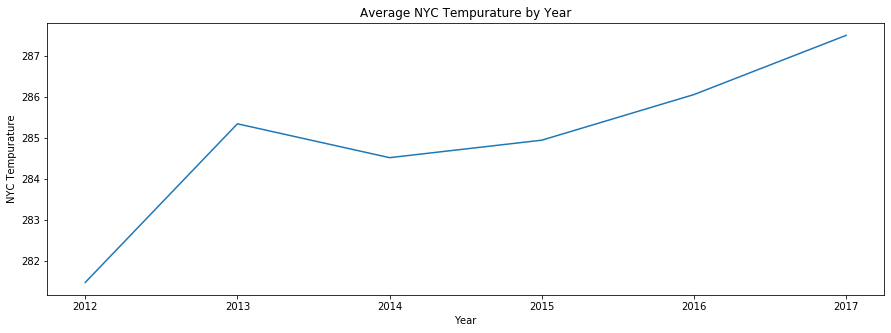

In [12]:
annual_df = eda_df.groupby('Year').mean()
annual_df.drop(index=[2012, 2017])
annual_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Year', y='NYC Tempurature', data=annual_df, ax=ax)
ax.set_title('Average NYC Tempurature by Year')

Plot Monthly trend in time series data

Text(0.5, 1.0, 'Average NYC Tempurature by Month')

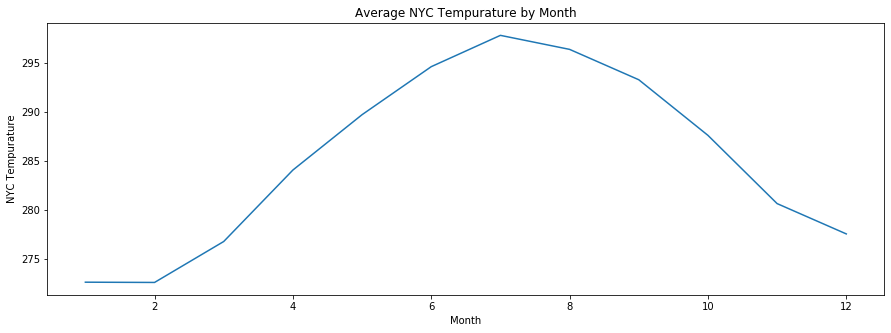

In [13]:
monthly_df = eda_df.groupby('Month').mean()
monthly_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Month', y='NYC Tempurature', data=monthly_df, ax=ax)
ax.set_title('Average NYC Tempurature by Month')

Plot daily trend in time series data

Text(0.5, 1.0, 'Average NYC Tempurature by Day of Year')

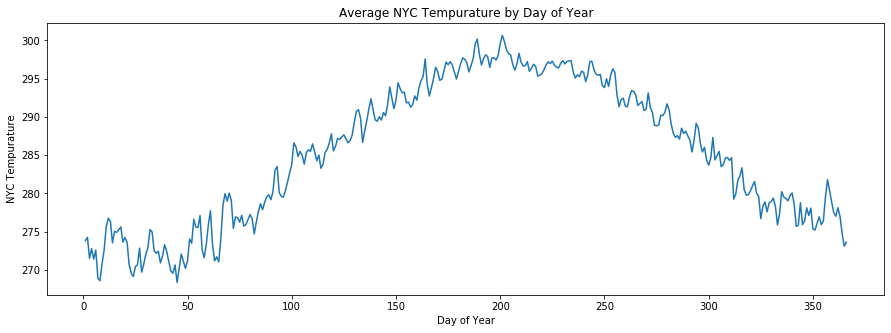

In [14]:
day_df = eda_df.groupby('Day of Year').mean()
day_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Day of Year', y='NYC Tempurature', data=day_df, ax=ax)
ax.set_title('Average NYC Tempurature by Day of Year')

Plot hourly trend in time series data

Text(0.5, 1.0, 'Average NYC Tempurature by Hour')

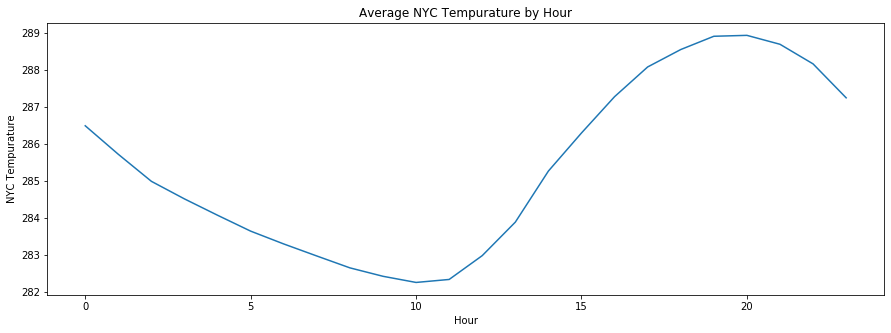

In [15]:
hourly_df = eda_df.groupby('Hour').mean()
hourly_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Hour', y='NYC Tempurature', data=hourly_df, ax=ax)
ax.set_title('Average NYC Tempurature by Hour')

# Model Data